In [1]:
### importing necessary libraries for data retrieval
import pandas_datareader.data as web
import datetime
import pandas as pd
import json
import pymongo
start=datetime.datetime(2018,1,1)## to determine date range parameters
end=datetime.datetime(2022,4,13)
from datetime import datetime##to work with time index
from pymongo import MongoClient## importing pymongo to be able to work with MongoDB

In [2]:
tesco_read=web.DataReader('TSCO', 'yahoo',start,end)## reading the data using DataReader package from Pandas which uses yahoo api

In [3]:
path_1="C:\\Users\\cifci\\Downloads\\Downloads 14 01 2020\\Data\\tesco_V2.csv"
tesco_read.to_csv(path_1)### save as csv

In [4]:
tesco_stock=pd.read_csv(path_1) ### read from csv

In [5]:
client = MongoClient("mongodb://localhost:27017") ## creating a connection to MongoDB and naming as client

In [6]:
datb=client["Stocks_V5"]##defining a database with the name Stocks

In [7]:
tsco_dict=tesco_stock.to_dict(orient="records")## converting to dictionary

In [8]:
datb.tsco.insert_many(tsco_dict)### creating a collection in the database with the name tsco

In [9]:
my_collection=datb.tsco## assigning collection to a variable

In [10]:
df_tesco=pd.DataFrame(list(my_collection.find()))##converting to a pandas dataframe

In [11]:

df_tesco.head()### checking the appearence of dataframe

,_id,Date,High,Low,Open,Close,Volume,Adj Close
0,6266ea8d66f646219f1f32ae,2018-01-02,76.730003,75.010002,75.349998,75.680000,1590000.0,71.520538
1,6266ea8d66f646219f1f32af,2018-01-03,76.360001,75.440002,75.839996,76.250000,786100.0,72.059212
2,6266ea8d66f646219f1f32b0,2018-01-04,77.720001,76.089996,76.510002,77.620003,1225700.0,73.353928
3,6266ea8d66f646219f1f32b1,2018-01-05,79.529999,77.690002,77.889999,79.440002,2160100.0,75.073883
4,6266ea8d66f646219f1f32b2,2018-01-08,79.720001,78.709999,79.169998,79.250000,1409700.0,74.894348


In [12]:
df_tesco.set_index(keys='Date', inplace=True)

<AxesSubplot:title={'center':'Stock Price (2018-2022)'}, xlabel='Date'>

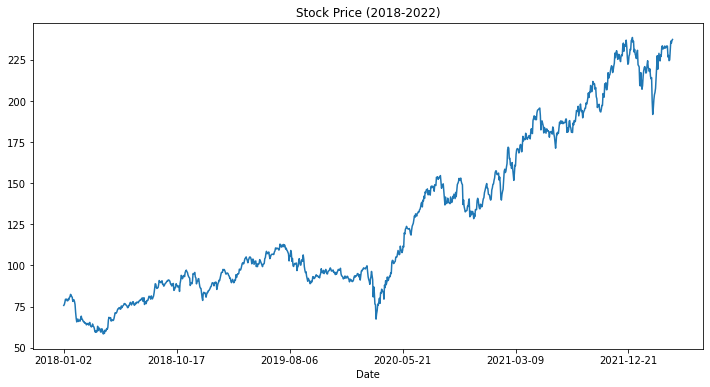

In [13]:
df_tesco['Close'].plot(figsize=(12,6), title='Stock Price (2018-2022)', kind='line')

   Data Cleaning

In [14]:
df_tesco=df_tesco.drop(labels=['Adj Close', 'Open', '_id', 'Low', 'High'], axis=1)##5 columns have been dropped

In [15]:
df_tesco.head()

,Close,Volume
Date,,
2018-01-02,75.680000,1590000.0
2018-01-03,76.250000,786100.0
2018-01-04,77.620003,1225700.0
2018-01-05,79.440002,2160100.0
2018-01-08,79.250000,1409700.0


In [16]:
df_tesco['Return']=df_tesco['Close'].pct_change()## a new column has been added to show daily returns

In [17]:
df_tesco.head()

,Close,Volume,Return
Date,,,
2018-01-02,75.680000,1590000.0,NaN
2018-01-03,76.250000,786100.0,0.007532
2018-01-04,77.620003,1225700.0,0.017967
2018-01-05,79.440002,2160100.0,0.023448
2018-01-08,79.250000,1409700.0,-0.002392


In [18]:
df_tesco = df_tesco.iloc[1: , :]##first row is excluded from the dataset

In [19]:
df_tesco

,Close,Volume,Return
Date,,,
2018-01-03,76.250000,786100.0,0.007532
2018-01-04,77.620003,1225700.0,0.017967
2018-01-05,79.440002,2160100.0,0.023448
2018-01-08,79.250000,1409700.0,-0.002392
2018-01-09,79.489998,1116600.0,0.003028
...,...,...,...
2022-04-07,230.979996,1289300.0,0.026943
2022-04-08,236.380005,851500.0,0.023379
2022-04-11,235.110001,756300.0,-0.005373


<AxesSubplot:xlabel='Date'>

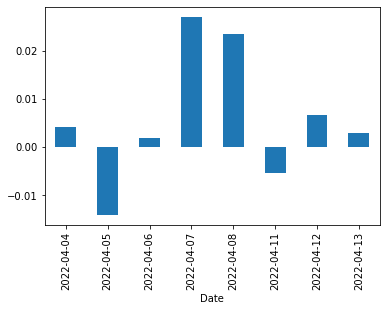

In [20]:
df_tesco['Return']['2022-04-04':'2022-13-04'].plot(kind='bar')

In [26]:
path_2="C:\\Users\\cifci\\Downloads\\Downloads 14 01 2020\\Data\\tesco_for_sql.csv"
df_tesco.to_csv(path_2)

In [27]:
import psycopg2### Using psycop2 connecting my local databsase
try:
    dbConnection = psycopg2.connect(
        user = "postgres",
        password = "sacq6/Ue",
        host = "127.0.0.1",
        port = "5432",
        database = "postgres")
    dbConnection.set_isolation_level(0) #
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE stock_data_v5;')
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if "dbConnection" in locals(): 
        dbConnection.close()

In [28]:
table_create_string = """
CREATE TABLE IF NOT EXISTS tesco_stock(
   date_time timestamp,
   Close numeric(6,3),
   Volume float,
   Return float
);
"""

try:
    dbConnection = psycopg2.connect(
        user = "postgres",
        password = "sacq6/Ue",
        host = "127.0.0.1",
        port = "5432",
        database = "stock_data_v5"
    )
    dbConnection.set_isolation_level(0) 
    dbCursor = dbConnection.cursor()
    dbCursor.execute(table_create_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if "dbConnection" in locals(): 
        dbConnection.close()

In [29]:
import csv

try:
    dbConnection = psycopg2.connect(
        user = "postgres",
        password = "sacq6/Ue",
        host = "127.0.0.1",
        port = "5432",
        database = "stock_data_v5"
    )
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = "INSERT INTO tesco_stock (date_time, Close, Volume, Return) VALUES (%s, %s, %s, %s)"
    with open('C:\\Users\\cifci\\Downloads\\Downloads 14 01 2020\\Data\\tesco_for_sql.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString, row)
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if "dbConnection" in locals(): 
        dbConnection.close()

In [30]:
import pandas as pd
import pandas.io.sql as sqlio
import seaborn as sns
import matplotlib.pyplot as plt

sql = """
SELECT
  date_time,
  Close,
  Volume,
  Return
FROM
  tesco_stock"""

try:
    dbConnection = psycopg2.connect(
        user = "postgres",
        password = "sacq6/Ue",
        host = "127.0.0.1",
        port = "5432",
        database = "stock_data_v3"
    )
    tesco_dataframe = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if "dbConnection" in locals(): 
        dbConnection.close()

In [31]:
tesco_dataframe.info

<bound method DataFrame.info of       date_time   close     volume    return
0    2018-01-03   76.25   786100.0  0.007532
1    2018-01-04   77.62  1225700.0  0.017967
2    2018-01-05   79.44  2160100.0  0.023448
3    2018-01-08   79.25  1409700.0 -0.002392
4    2018-01-09   79.49  1116600.0  0.003028
...         ...     ...        ...       ...
1073 2022-04-07  230.98  1289300.0  0.026943
1074 2022-04-08  236.38   851500.0  0.023379
1075 2022-04-11  235.11   756300.0 -0.005373
1076 2022-04-12  236.69   817400.0  0.006720
1077 2022-04-13  237.38   773300.0  0.002915

[1078 rows x 4 columns]>

In [32]:
final_stock_dataframe=pd.DataFrame(tesco_dataframe)

In [33]:
final_stock_dataframe.set_index(keys='date_time', inplace=True)

<AxesSubplot:xlabel='date_time'>

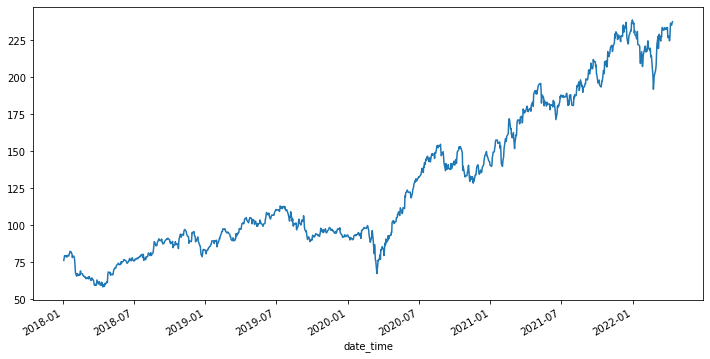

In [34]:
final_stock_dataframe["close"].plot(figsize=(12,6))

<AxesSubplot:ylabel='Frequency'>

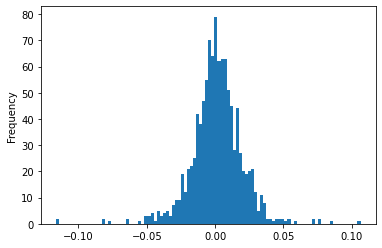

In [35]:
final_stock_dataframe["return"].plot(kind='hist', bins=100)

<AxesSubplot:xlabel='date_time'>

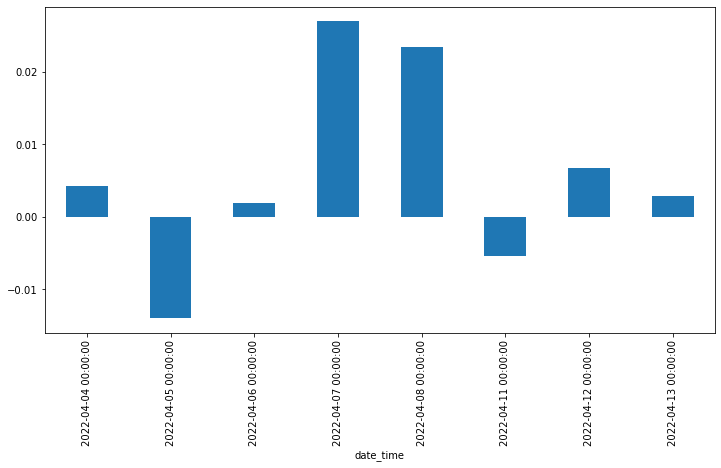

In [36]:
final_stock_dataframe["return"]['2022-04-04':'2022-12-04'].plot(kind='bar', figsize=(12,6))

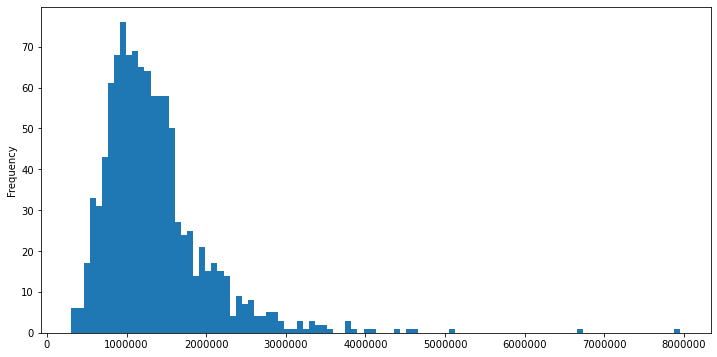

In [44]:
final_stock_dataframe['volume'].plot(kind='hist', bins=100, figsize=(12,6))
plt.ticklabel_format(style='plain')

In [40]:
final_stock_dataframe.head()

,close,volume,return
date_time,,,
2018-01-03,76.25,786100.0,0.007532
2018-01-04,77.62,1225700.0,0.017967
2018-01-05,79.44,2160100.0,0.023448
2018-01-08,79.25,1409700.0,-0.002392
2018-01-09,79.49,1116600.0,0.003028
